In [46]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [47]:
import numpy as np
import pandas as pd

In [48]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [49]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [50]:
engine = create_engine("sqlite:///resources/hawaii.sqlite")

In [51]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [52]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [53]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [54]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

2016-08-23
2015


<IPython.core.display.Javascript object>


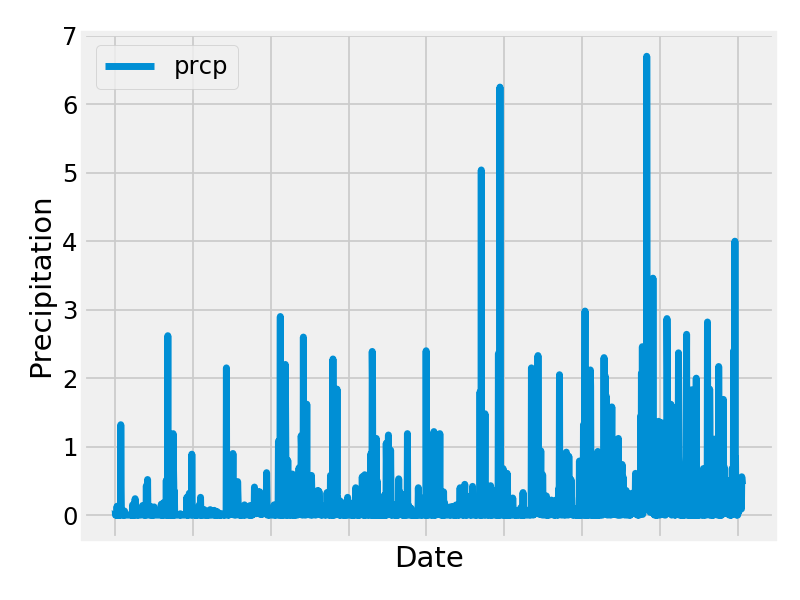

In [55]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last day of data
yearago =dt.date(2017, 8, 23)- dt.timedelta(days=365)
print(yearago)

# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).\
filter(Measurement.date > yearago).filter(Measurement.prcp !="").all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip)

# Sort the dataframe by date
precip_df.sort_values(by="date")

print(len(precip_df))

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(y="prcp")
plt.xlabel("Date")
plt.ylabel("Precipitation")

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are of

plt.tight_layout()

In [56]:
precip_df = precip_df.set_index("date", drop=True)
# Use Pandas to calcualte the summary statistics for the precipitation data
Measurement_df = pd.DataFrame(session.query(Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).all())
Measurement_df["prcp"].describe()


count    18103.000000
mean         0.160644
std          0.468746
min          0.000000
25%          0.000000
50%          0.010000
75%          0.110000
max         11.530000
Name: prcp, dtype: float64

In [57]:
# How many stations are available in this dataset?
stations = session.query(Measurement.station).group_by(Measurement.station).count()
stations

9

In [58]:
# What are the most active stations?
# List the stations and the counts in descending order.
activity = pd.DataFrame(session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).all(),\
                        columns = ["station", "tobs_count"]).set_index("station").sort_values("tobs_count", ascending=False)
activity

tobs_count
station                
USC00519281        2772
USC00519397        2724
USC00513117        2709
USC00519523        2669
USC00516128        2612
USC00514830        2202
USC00511918        1979
USC00517948        1372
USC00518838         511

In [59]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281").all()

most_active


[(54.0, 85.0, 71.66378066378067)]

<IPython.core.display.Javascript object>


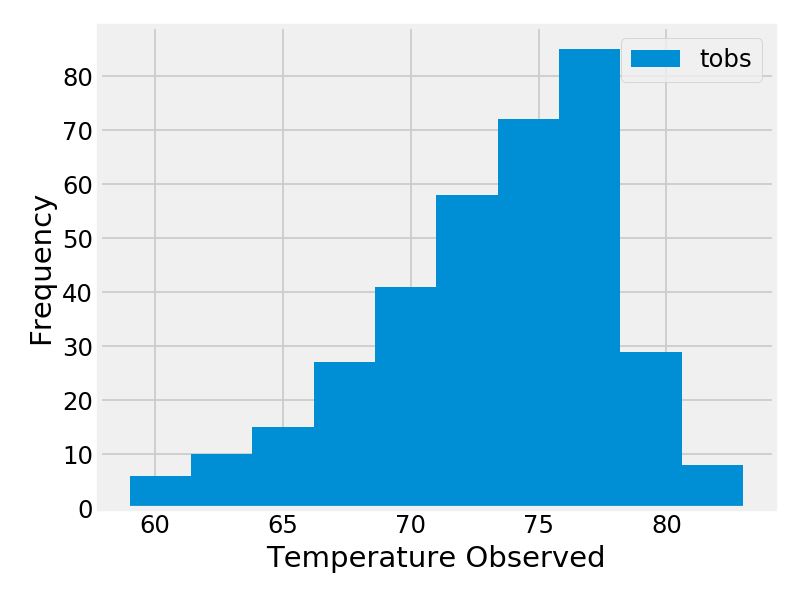

In [69]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_df = pd.DataFrame(session.query(Measurement.tobs).filter(Measurement.station == "USC00519281")\
                                            .filter(Measurement.date > yearago).all())

most_active_df.plot.hist(y="tobs")
plt.xlabel("Temperature Observed")
plt.tight_layout()

In [61]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-05-28', '2012-06-05')[0])

(68.0, 73.56451612903226, 78.0)


In [63]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_temps("2016-04-08", "2016-04-18")[0]
print(trip)

(66.0, 73.73134328358209, 80.0)


In [68]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)



In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



Part 2

In [38]:
from flask import Flask, jsonify
engine = create_engine("sqlite:///resources/hawaii.sqlite")
Base = automap_base()
Base.prepare(engine, reflect=True)
app = Flask(__name__)

In [39]:
@app.route("/")
def index():
    return "Available Pages:"
    session.close()

In [40]:
@app.route("/api/v1.0/precipitation")
def precip():
    session = Session(engine)
    return jsonify(session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date > yearago).filter(Measurement.prcp !="").all())

In [41]:
@app.route("/api/v1.0/stations")
def stations():
    session = Session(engine)
    return jsonify(session.query(Measurement.station).group_by(Measurement.station).all())

In [42]:
@app.route("/api/v1.0/tobs")
def tobs():
    session = Session(engine)
    return jsonify(session.query(Measurement.tobs).all())

In [43]:
@app.route("/api/v1.0/<start>")
def startonly(start):
    session = Session(engine)
    return jsonify(calc_temps(start, dt.date.today())[0])

In [44]:
@app.route("/api/v1.0/<start>/<end>")
def startend(start, end):
    return jsonify(calc_temps(start, end)[0])

In [45]:
if __name__ == '__main__':
    from werkzeug.serving import run_simple
    run_simple('localhost', 9000, app)

 * Running on http://localhost:9000/ (Press CTRL+C to quit)
127.0.0.1 - - [11/Aug/2018 12:38:36] "GET /api/v1.0/2016-03-01 HTTP/1.1" 200 -
127.0.0.1 - - [11/Aug/2018 12:38:51] "GET /api/v1.0/2016-03-01/2016-04-01 HTTP/1.1" 200 -


(58.0, 74.89168525007965, 87.0)
